In [1]:
from numpy import append, array, exp, \
                linspace, loadtxt, log10, pi, meshgrid, \
                savetxt, sqrt, where, ones, percentile,trapz
from scipy import special
import matplotlib.pyplot as plt
import time, glob, os, sys
import multiprocessing as mp
import stan
import pandas as pd
from astropy.table import Table, vstack
import numpy as np
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from bayestar import *

In [2]:
data_dir = "../BayeSFH-NGC0628/data/"

# **Core**

In [3]:
code = """

    functions{
        real P(int N1, int N2, vector v, matrix M) {
            vector[N1] Mj;
            vector[N1] ln_Mj;

            Mj= M*v;
            for (j in 1:N1){
                if (Mj[j]<=0.)
                    Mj[j] = 1.;
            }
            ln_Mj = log(Mj);
            return sum(ln_Mj);
        }
    }

    data {
        int<lower=0> Nj; // number of data
        int<lower=0> Ni; // number of isochrones
        matrix[Nj,Ni] Pij; // Probability matrix
        matrix[Nj,Ni] Cij; // Normalization matrix
    }

    parameters {
        simplex[Ni] a;
    }

    model {
        target += dirichlet_lpdf(a | rep_vector(1., Ni));
        target += P(Nj,Ni,a,Pij);
        target += -1.*P(Nj,Ni,a,Cij);
    }

    """

class Base():

    def Normal_MGk(self, fw_dat,fw_err,Iso_sig):    # Error model apparent maginute
        sig2 = fw_err*fw_err + Iso_sig*Iso_sig          # And normal Isochrone 
        
        return  lambda fw_iso : exp( -0.5*(fw_dat-fw_iso)**2 / sig2 ) / sqrt(2.*pi*sig2)

    def Phi_MGk(self,fwj2, sig_fwj2, fwklim, sig_i2):
        b = sig_i2*sig_i2 + sig_fwj2*sig_fwj2
        b1 = sig_i2*sig_i2/b
        b2 = sig_fwj2*sig_fwj2/b
        b3 = sig_i2*sig_i2/sqrt(b)
        return  lambda fw_i2 : special.ndtr( ( fwklim - b1*fwj2 - b2*fw_i2 ) / b3 )

    def IMF_Krp(self, m, ml=0.1, mint=0.5, mu=350.,a1=1.3,a2=2.3):

        h2 = (mu**(1.-a2)-mint**(1.-a2))/(1.-a2)
        h1 = (mint**(1.-a1)-ml**(1.-a1))/(1.-a1)

        c1 = 1./(h1+h2*mint**(a2-a1))
        c2 = c1*mint**(a2-a1)

        c = ones(len(m))
        c[where(m < mint)] = c1
        c[where(m >= mint)] = c2

        a = ones(len(m))
        a[where(m < mint)] = -a1
        a[where(m >= mint)] = -a2
        imf = c*m**a

        return(imf)

    def P_ij_map(self, IDp):

        if not os.path.exists('pij_cij_results'):
            os.mkdir('pij_cij_results')
        fw = '_'.join([str(i) for i in self.fw_lims])
        sig_iso = '_'.join([str(i) for i in self.sig_fw])
        
        filename_p = '%s_Pij_Data_LimMag%s_%srows_%siso_IsoModel_sig%s_IMF_%s_Simple.txt' % \
            (IDp,fw,str(self.N_dat),str(self.NIso),sig_iso.replace('.','p'), self.IMF)    ## Opening file
        fp = open(os.path.join("pij_cij_results",filename_p),'a')
        args = []

         ## Pij is calcutated row by row, i.e. fix j-th dat and run each i-th isochrone.

        args = np.arange(0,self.N_dat,1)

        with mp.Pool(mp.cpu_count()-1) as p:         ## Pooling Pij rows using all the abailable CPUs (Parallel computation)
            results = p.map(self.P_ij_row_map, args)
            Pij_out=[]
            for [j,wr] in results:
                fp.write('{}'.format(' '.join(wr))+'\n')
                Pij_out.append(array(wr, dtype=float))
        fp.close()
        
        return([Pij_out, filename_p])

    def P_ij_row_map(self, ids):

        j = ids
        
        P_fw = []
        Phi_fw = []
        for i in range(1,self.N_mags+1):
            P_fw.append(self.Normal_MGk(self.dat[i*2][j],self.dat[i*2+1][j], self.sig_fw[i-1]))
            Phi_fw.append(self.Phi_MGk(self.dat[i*2][j],self.dat[i*2+1][j], self.fw_lims[i-1], self.sig_fw[i-1]))
            
        wr=[]
        for i in range(self.NIso):                    ## Isochrone loop

            if self.IMF == "Krp":
                imf_p = self.IMF_Krp(self.Iso[i][1])
            elif self.IMF == "Slp":
                print("Not available at the moment")
                #imf_p = self.IMF_Salp(Iso[i][1])
            else:
                # Default
                imf_p = self.IMF_Krp(self.Iso[i][1])
                
            Ps_Phis = 1            
            for k in range(self.N_mags):
                Ps_Phis *= P_fw[k](self.Iso[i][k+2])*Phi_fw[k](self.Iso[i][k+2])
            
            Intg = imf_p*Ps_Phis

            ## Interand
            p = trapz(Intg,self.Iso[i][1])

            wr.append(str(p))

        return([j,wr])

    def C_ij_map(self, IDc):

        fw = '_'.join([str(i) for i in self.fw_lims])
        sig_iso = '_'.join([str(i) for i in self.sig_fw])

        filename_c = '%s_Cij_Data_LimMag%s_%srows_%siso_IsoModel_sig%s_IMF_%s_Simple.txt' % \
            (IDc,fw,str(self.N_dat),str(self.NIso),sig_iso.replace('.','p'), self.IMF)
        
        fp = open(os.path.join("pij_cij_results",filename_c),'a')   ## output matrix
        # Cij is calcutated row by row, i.e. fix j-th dat and run each i-th isochrone.

        args = np.arange(0,self.N_dat,1)

        with mp.Pool(mp.cpu_count()-1) as p:
            results = p.map(self.C_ij_row_map, args)
            Cij_out=[]
            for [j,wr] in results:
                fp.write('{}'.format(' '.join(wr))+'\n')
                Cij_out.append(array(wr, dtype=float))
        fp.close()
        
        return(Cij_out)

    def C_ij_row_map(self,ids):

        j = ids
      
        Phi_fw = []
        for i in range(1,self.N_mags+1):
            Phi_fw.append(self.Phi_MGk(self.dat[i*2][j],self.dat[i*2+1][j], self.fw_lims[i-1], self.sig_fw[i-1]))


        wr = []
        for i in range(self.NIso):

            if self.IMF == "Krp":
                imf_c = self.IMF_Krp(self.Iso[i][1])
            elif self.IMF=="Slp":
                print("Not available at the moment")
                #imf_c = self.IMF_Salp(Iso[i][1])
            else:
                imf_c = self.IMF_Krp(self.Iso[i][1])

            
            Phis = 1            
            for k in range(self.N_mags):
                Phis *= Phi_fw[k](self.Iso[i][k+2])
                
            intg_c = imf_c*Phis
            p_c = trapz(intg_c,self.Iso[i][1])

            wr.append(str(p_c))

        return ([j,wr])

    def ai_samp(self, ID, Name):


        ### Data for STAN ###
        dats = {'Nj' : self.N_dat,
                'Ni' : self.NIso,
                'Pij': self.P_ij,
                'Cij': self.C_ij  }

        ############ Running pystan ############

        sm = stan.build(code, data=dats, random_seed=1234)
        fit = sm.sample(num_samples=self.N_smp, num_chains=self.N_wlk, num_warmup=200)
        a_sp = fit["a"].T

        ######### Saving the MCMC sample #########

        N_iso = len(a_sp[0])

        a_perc = array([ percentile(ai,[10,50,90]) for ai in a_sp.T])       ##  10th, 50th, 90th percentiles

        sfh=array([self.Z_age_isos[:,0], self.Z_age_isos[:,1], a_perc[:,0], a_perc[:,1], a_perc[:,2] ]).T

        ##
        hd='Z,Log_age,p10,p50,p90'
        filename = ID+"_ai"+Name+"_Niter"+str(len(a_sp))+".txt"
        savetxt(filename, sfh, header=hd, fmt="%.6f", delimiter=",",comments='')
        
        return filename

In [4]:
class SFH(Base):
    """
    Base class for Bayesian Star formation history analysis
    """
    def __init__(self,df=None,N_wlk=20, N_smp=500, fw_lims=[30.,30.0,30.0], 
                 A_fw=[0, 0, 0], sig_fw=[0.1, 0.1,0.1], N_mags=3, 
                 dismod=29.67,isofiles='', isodir=None, ph_sup=100,m_inf=0.1,
                 IMF='Krp',parallel=True):
        
        """
        Parameters
        ----------
        df: pd.DataFrame,
        N_wlk: int,
        N_smp: int,
        fw_lim: list(floats),
        A_fw: list(floats),
        sig_fw: list(floats),
        N_mags: int,
        dismod: float,
        isofiles: str,
        isodir: str,
        ph_sup: int,
        m_inf: float,
        IMF: str,
        parallel: bool
        
        """
        
        self.N_wlk, self.N_smp = N_wlk, N_smp
        
        self.A_fw1= A_fw
        
        self.fw_lims = array(fw_lims)
        
        self.sig_fw = array(sig_fw)
        
        self.N_mags = N_mags
        
        if isodir is None:
            isodir = f'{data_dir}/test_files/Isochrone.test'
        
        ########### Reading Isochrones ###########
        if (isofiles != ''):
            filelist = []
            f = open(isofiles, "r")
            lines = f.readlines()
            for line in lines:
                filelist.append(line.replace('\n',''))
        
            self.filelist = filelist
            f.close()
        else:
            filelist = glob.glob(os.path.join(isodir, "*.isoc"))
            self.filelist = filelist
        
        #               F435W  F555W  F814W
        #   ph   mass   mag1   mag2   mag3  Z  log_age
        iso = array([ loadtxt(k) for k in sorted(filelist) ], dtype=object)
        
        self.ages = [float(i.split('Myr')[0].split('AGE')[1]) for i in self.filelist]
        
        self.Z_age_isos = array([ loadtxt(k)[0][-2:] for k in sorted(self.filelist) ], dtype=object)
        
        ph_sup = 100
        m_inf = 0.1
        
        for l in range(len(iso)):
            iso[l] = iso[l][where( (iso[l].T[1]>=m_inf) & (iso[l].T[0]<=ph_sup))]       ## mass Truncation & stellar phase Truc
            iso[l] = iso[l].T
        
        self.Iso = iso
        ################################### DATA #######################################
        
        #  0      1       2        3         4          5         6          7
        #  RA    DEC     fw1   fw1_error    fw2     fw2_error    fw3     fw3_error
        if df is None:
            df = pd.read_fwf(f"{data_dir}/test_files/data.test", sep=' ')
            col_dict = {
                        'F435Wmag'        : 'fw1',
                        'F435Wmag_err'    : 'fw1_error',
                        'F555Wmag'        : 'fw2',
                        'F555Wmag_err'    : 'fw2_error',
                        'F814Wmag'        : 'fw3',
                        'F814Wmag_err'    : 'fw3_error'}

            df = df.rename(columns=col_dict)
        keys = ['RA', 'DEC']
        for i in range(1,N_mags+1):
            keys += [f"fw{i}", f"fw{i}_error"]
            
        try:
            dt = df[keys]
        except:
            print("Data Frame input keys: ", keys)
            raise Exception("Input data keys don't match!")
        
        step = int(1)
        dat = dt.values.astype(float)
        msg = "from %d... (FW <= %s)" % (len(dat),str(fw_lims))
        
        # Completeness Filtering
        for i in range(1,N_mags+1):
            dat = dat[where((dat[:,int(i)*2] < fw_lims[i-1]) )]        # Truncate by apparent magnitude
        
        w_dat = dat[:,0]
        
        
        # Adding Extinction
        for i in range(1,N_mags+1):
            dat[:,int(i)*2] -= A_fw[i-1] + dismod
        
        print ("Selecting %d %s" % (len(dat), msg))
        dat = dat[::step]
        dat = dat
        self.dat = dat.T
        
        self.N_dat = len(self.dat[0])
        self.NIso = len(self.Iso)
        
        self.parallel = parallel
        self.IMF = IMF

    def __call__(self):
        ########################### Execution Routines #################################
        
        start = time.time()
        print ("Starting Pij, Cij computation")
        if (self.parallel):
            print ("\tParallel mode...")
        
            ID = str(int(time.time()))
        
            self.Pij_reslt = self.P_ij_map(ID)
            self.P_ij, Pij_name = self.Pij_reslt[0], self.Pij_reslt[1]
            
            Name = Pij_name[Pij_name.find("_Pij")+4:Pij_name.find(".txt")]
        
            self.C_ij = self.C_ij_map(ID)
        
        else:
            print ("\tSequential mode... Not available for the moment")
           # P_ij(dat, N_dat, r_int, iso, N_iso)
        print ("Finished                                ")
        
        
        end = time.time()
        
        elapsed = end - start
        
        print ("Elapsed time: %02d:%02d:%02d" % (int(elapsed / 3600.), int((elapsed % 3600)/ 60.), elapsed % 60))
        
        ###########################################
        filename = self.ai_samp(ID, Name)
        print("Completed!!!")
        return filename

In [5]:
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

# **Testing**

In [6]:
# HST
sfh = SFH()

Selecting 3249 from 3672... (FW <= [30.0, 30.0, 30.0])


In [9]:
fname=sfh()

Starting Pij, Cij computation
	Parallel mode...
Finished                                
Elapsed time: 00:00:11


Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_kzhpznha/model_4xnllnqo.stan', line 10, column 16: A
    control flow statement inside function P depends on argument v. At
    '/tmp/httpstan_kzhpznha/model_4xnllnqo.stan', line 32, column 30 to
    column 31, the value of v depends on parameter(s): a.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.00062 seconds
  1000 transitions using 10 leapfrog steps per transition would take 6.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000385 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.85 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001003 seconds
  1000 transitions using 10 leapfrog steps per transition would take 10.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000407 seconds
  1000 transitions using 10 leapfrog steps per tran

Completed!!!


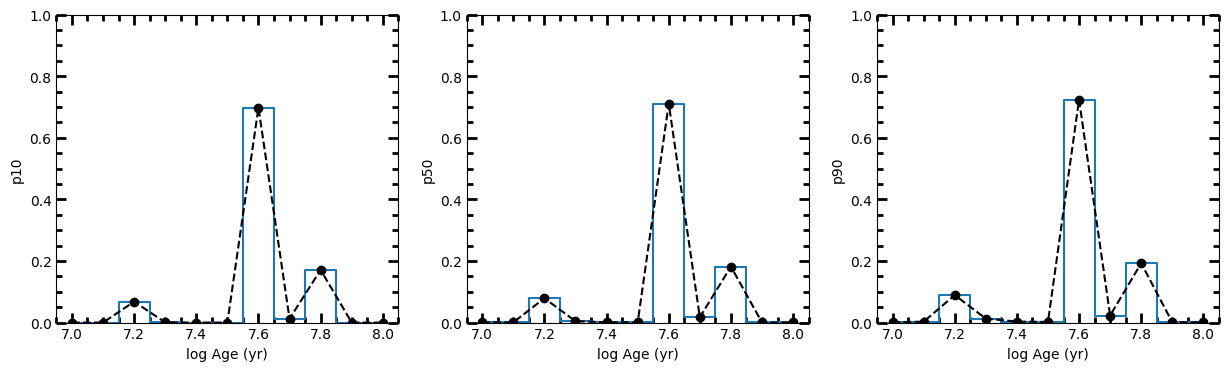

In [8]:
df_out = pd.read_csv(fname)

fig, ax = plt.subplots(1,3, figsize=(15,4))

x = df_out['Log_age']
y = df_out['p10']

ax[0].step(x,y,where='mid')
ax[0].plot(x,y,'--ok')

x = df_out['Log_age']
y = df_out['p50']

ax[1].step(x,y,where='mid')
ax[1].plot(x,y,'--ok')

x = df_out['Log_age']
y = df_out['p90']

ax[2].step(x,y,where='mid')
ax[2].plot(x,y,'--ok')

ps =  [10,50,90]
for i in range(3):

    ax[i].set_xlabel('log Age (yr)')
    ax[i].set_ylabel(f'p{ps[i]}')

    ax[i].xaxis.set_minor_locator(AutoMinorLocator())
    ax[i].yaxis.set_minor_locator(AutoMinorLocator())
    ax[i].tick_params(which='both', width=2,direction="in", top = True,right = True,
                   bottom = True, left = True)
    ax[i].tick_params(which='major', length=7,direction="in")
    ax[i].tick_params(which='minor', length=4, color='black',direction="in")
    ax[i].set_ylim(0,1)